In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

Simulate daily conversions over 100 days with creative fatigue modeled via a Hill function and a spend carryover effect (adstock).

In [3]:
# Simulate days
days = 100
spend = np.random.gamma(shape=5.0, scale=20.0, size=days)

# Simulated fatigue effect (diminishing returns)
def hill_function(x, beta, K, S):
    return beta * (x ** S) / (K ** S + x ** S)

# True parameters (unknown to model)
true_params = dict(beta=500, K=300, S=1.5)

# Simulate adstock (carryover)
def adstock(x, decay):
    result = np.zeros_like(x)
    for t in range(len(x)):
        result[t] = x[t] + (result[t - 1] * decay if t > 0 else 0)
    return result

adstocked_spend = adstock(spend, decay=0.5)
conversions = hill_function(adstocked_spend, **true_params)
conversions += np.random.normal(scale=25, size=days)  # add noise

To estimate the best-fit parameters of an adstock + Hill model using observed spend and conversions data by applying nonlinear curve fitting 

from scipy.optimize import curve_fit

def adstock_hill_model(x, decay, beta, K, S):
    x_ad = adstock(x, decay)
    return hill_function(x_ad, beta, K, S)

p0 = [0.5, 400, 200, 1.0]  # initial guesses

params_opt, _ = curve_fit(adstock_hill_model, spend, conversions, p0=p0, bounds=([0, 0, 0, 0], [1, 1000, 1000, 5]))
decay_opt, beta_opt, K_opt, S_opt = params_opt


To visualize and compare the actual conversions against the predicted conversions generated by the fitted adstock + Hill fatigue model over time.

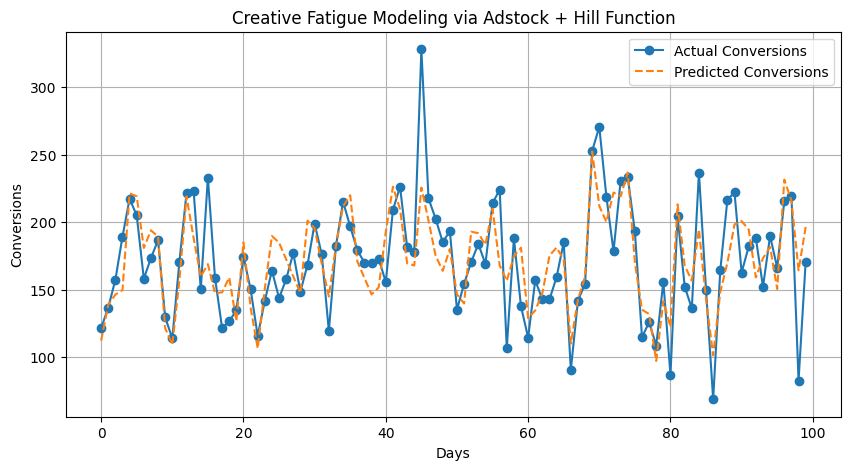

In [6]:
predicted = adstock_hill_model(spend, *params_opt)

plt.figure(figsize=(10, 5))
plt.plot(conversions, label="Actual Conversions", marker="o")
plt.plot(predicted, label="Predicted Conversions", linestyle="--")
plt.legend()
plt.title("Creative Fatigue Modeling via Adstock + Hill Function")
plt.xlabel("Days")
plt.ylabel("Conversions")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Use adstocked spend as feature
X = adstocked_spend.reshape(-1, 1)
y = conversions

# Fit linear regression
model = LinearRegression()
model.fit(X, y)

# Predict
y_pred = model.predict(X)

# Evaluate
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R^2 Score: {r2:.3f}")

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(X, y, label="Actual", alpha=0.6)
plt.plot(X, y_pred, color="red", label="Linear Fit")
plt.title("Linear Regression on Adstocked Spend")
plt.xlabel("Adstocked Spend")
plt.ylabel("Conversions")
plt.legend()
plt.grid(True)
plt.show()